In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
import os
#os.chdir("/data2/mito_lineage")

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import filt_high, filt_low
from icecream import ic

0.4.2


In [4]:
INDIR=""#"data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones"
OUTDIR=""#"data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones/variants"
N_DONORS=5 
vars_to_plot=10
sample_names="Control,Flt3l,Input"
n_clones=20
var_thresh = 0.001
vcf_f=None

In [39]:
if vcf_f is None:
    vcf_f= join(dirname(INDIR), "cellSNP.base.vcf")

vcf=pd.read_csv(vcf_f,
                sep='\t').fillna("N")
vcf.index = vcf.apply(lambda x: str(x["POS"])+x["REF"] + ">" + x["ALT"],axis=1)
vcf

,index_x,#CHROM,POS,REF_x,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,...,n_cells_over_20_y,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Control/MT/cellr_True/Control_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,index,REF,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
7373A>G,73A>G,chrM,73,73A,G,0.996919,0.382955,119,116,1,...,329,2,73A>G,73A,0.995236,0.339875,2768,2699,3,1
146146T>C,146T>C,chrM,146,146T,C,0.993106,0.591151,2,1,2,...,N,N,146T>C,146T,0.990833,0.665951,15,6,6,2
150150C>T,150C>T,chrM,150,150C,T,0.979327,0.670372,61,49,3,...,177,3,150C>T,150C,0.977151,0.800561,714,664,9,3
195195T>C,195T>C,chrM,195,195T,C,0.990257,0.623396,44,31,4,...,22,4,195T>C,195T,0.971955,0.66947,1103,1027,11,4
248248A>G,248A>G,chrM,248,248A,G,0.705534,4.21659,24,14,5,...,88,5,248A>G,248A,0.898661,1.70171,242,222,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635616356T>A,N,chrM,16356,N,A,N,N,N,N,N,...,N,N,16356T>A,16356T,0.951078,0.0143875,0,0,363,491
1636216362T>G,N,chrM,16362,N,G,N,N,N,N,N,...,N,N,16362T>G,16362T,1,0.0128357,0,0,365,492
1638716387A>G,N,chrM,16387,N,G,N,N,N,N,N,...,N,N,16387A>G,16387A,0.889789,0.0131121,0,0,366,493
1651216512T>A,N,chrM,16512,N,A,N,N,N,N,N,...,N,N,16512T>A,16512T,0.946026,0.0150404,0,0,367,494


In [6]:
curr_indir=join(INDIR, f"lineage{n_clones}")

In [7]:
#donors_indir = join(INDIR, "multiplex")
#out_f = os.path.join(OUTDIR, f"variants_violin_top{vars_to_plot}")

In [8]:
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}
#if not os.path.exists(OUTDIR):
#    os.mkdir(OUTDIR)
cells_meta = pd.read_csv(join(curr_indir, "cells_meta.tsv"), sep='\t')
cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64", "lineage":"Int64", "lineage_index":"Int64"})
cells_meta = cells_meta.set_index("ID")
cells_meta

,Unnamed: 0,donor_index,new index,raw ID,condition,donor,lineage,lineage_index
ID,,,,,,,,
AAACGAATCTTACTCA-1_Input,0,1,1,AAACGAATCTTACTCA-1,Input,0,13,1
AAGATAGTCGGTACTA-1_Input,1,2,9,AAGATAGTCGGTACTA-1,Input,0,5,1
AATGTCGCACCACGAC-1_Input,2,3,13,AATGTCGCACCACGAC-1,Input,0,5,2
AGGCGAAAGTGCTGAG-1_Input,3,4,32,AGGCGAAAGTGCTGAG-1,Input,0,5,3
CAACCAACACCGTCTT-1_Input,4,5,50,CAACCAACACCGTCTT-1,Input,0,4,1
...,...,...,...,...,...,...,...,...
TTTACGTCATAGATAG-1_Flt3l,833,834,4752,TTTACGTCATAGATAG-1,Flt3l,4,NaN,NaN
TTTACGTTCGTTCCGT-1_Flt3l,834,835,4756,TTTACGTTCGTTCCGT-1,Flt3l,4,NaN,NaN
TTTGCGCTCTTCCACG-1_Flt3l,835,836,4776,TTTGCGCTCTTCCACG-1,Flt3l,4,NaN,NaN


In [9]:
cells_meta.dropna().sort_values(['donor', 'lineage', 'lineage_index', 'donor_index'])

,Unnamed: 0,donor_index,new index,raw ID,condition,donor,lineage,lineage_index
ID,,,,,,,,
GTTATTCCAATGCACT-1_Control,123,124,533,GTTATTCCAATGCACT-1,Control,0,0,1
AAATGAGGTAATGTAG-1_Flt3l,168,169,747,AAATGAGGTAATGTAG-1,Flt3l,0,0,2
AACGTACTCTCGTAGA-1_Flt3l,190,191,856,AACGTACTCTCGTAGA-1,Flt3l,0,0,3
AACTTGGAGAGACTCG-1_Flt3l,192,193,874,AACTTGGAGAGACTCG-1,Flt3l,0,0,4
ACAAGCTGTTCTTTCA-1_Flt3l,219,220,966,ACAAGCTGTTCTTTCA-1,Flt3l,0,0,5
...,...,...,...,...,...,...,...,...
TCAGGTAGTTCCGCGA-1_Flt3l,707,708,4034,TCAGGTAGTTCCGCGA-1,Flt3l,4,19,31
TGATGCAGTGCCCAGT-1_Flt3l,738,739,4213,TGATGCAGTGCCCAGT-1,Flt3l,4,19,32
TGATTTCAGGATTGCG-1_Flt3l,740,741,4223,TGATTTCAGGATTGCG-1,Flt3l,4,19,33


In [10]:
cells_meta['donor'].unique()

<IntegerArray>
[0, 1, 2, 3, 4]
Length: 5, dtype: Int64

### Load AD , DP, vcf for each clone and extract variants using filt_high (remove donor-specific) and filt_low (only variants above certain var_thresh in clone)

In [11]:
variants_d = {}
all_AF = []
for d in np.arange(N_DONORS):
    donor_cells = pd.read_csv(join(curr_indir, f"donor{d}_cells_meta.tsv"), sep='\t').dropna()
    for n_cl in range(n_clones):
        prefix=f"donor{d}_lineage{n_cl}"
        curr_vcf = pd.read_csv(join(curr_indir, f"{prefix}.vcf"), sep='\t')
        #ad, dp = wrap_load_mtx(curr_indir, prefix=prefix)
        try:
            # get dense matrix with 
            AF_df, DP_df = wrap_load_mtx_df(curr_indir, oth_f=False, prefix=prefix,
                         columns=('Variant', 'Cell', 'integer'), inc_af=True, as_dense=True)
            assert(AF_df.shape==DP_df.shape)
            assert(curr_vcf.shape[0] == AF_df.shape[0])
            curr_cells_meta = pd.read_csv(join(curr_indir, f"{prefix}.labels.txt")).set_index("new index")
            curr_lineage = donor_cells[donor_cells['lineage']==n_cl].sort_values("lineage_index").set_index("ID")
            assert(curr_lineage.shape[0]==AF_df.shape[1])
            AF_df.columns = curr_lineage.index
            
            curr_vcf.index = curr_vcf.fillna("N").apply(lambda x: str(x["POS"]) + x["REF"]+">"+x["ALT"], axis=1)
            AF_df.index=curr_vcf.index # iloc[curr_cells['lineage_index']-1].index
            AF_df = AF_df.loc[filt_high(AF_df, 0.8)]
            AF_df = AF_df.loc[filt_low(AF_df, var_thresh)]
            all_AF.append(AF_df)
            variants_d[(d,n_cl)] = AF_df.index
            
        except TypeError:
            print(f"No cells in donor {d} cluster {n_cl}")


donor0_lineage0
donor0_lineage1
donor0_lineage2
donor0_lineage3
donor0_lineage4
donor0_lineage5
donor0_lineage6
donor0_lineage7
donor0_lineage8
donor0_lineage9
donor0_lineage10
donor0_lineage11
donor0_lineage12
donor0_lineage13
donor0_lineage14
donor0_lineage15
donor0_lineage16
donor0_lineage17
donor0_lineage18
donor0_lineage19
donor1_lineage0
donor1_lineage1
donor1_lineage2
donor1_lineage3
donor1_lineage4
donor1_lineage5
donor1_lineage6
donor1_lineage7
donor1_lineage8
donor1_lineage9
donor1_lineage10
donor1_lineage11
donor1_lineage12
donor1_lineage13
donor1_lineage14
donor1_lineage15
donor1_lineage16
donor1_lineage17
donor1_lineage18
donor1_lineage19
donor2_lineage0
donor2_lineage1
donor2_lineage2
donor2_lineage3
donor2_lineage4
donor2_lineage5
donor2_lineage6
donor2_lineage7
donor2_lineage8
donor2_lineage9
donor2_lineage10
donor2_lineage11
donor2_lineage12
donor2_lineage13
donor2_lineage14
donor2_lineage15
donor2_lineage16
donor2_lineage17
donor2_lineage18
donor2_lineage19
donor3_lin

## Concat the AF matrix, and filter cells_meta and vcf

In [12]:
all_AF_df = pd.concat(all_AF, axis=1, sort=False)
ic(cells_meta.shape)
cells_meta = cells_meta.loc[all_AF_df.columns]
ic(cells_meta.shape)

ic(vcf.shape)
variant_df = vcf.loc[all_AF_df.index]
ic(variant_df.shape)
variant_df=pd.concat((variant_df, vu.type_of_variants(variant_df.index)), axis=1)
ic(variant_df.shape)

ic| cells_meta.shape: (4507, 8)
ic| cells_meta.shape: (2538, 8)
ic| vcf.shape: (495, 25)
ic| variant_df.shape: (422, 25)


variants
Index(['7373A>G', '146146T>C', '150150C>T', '347N>T', '477477T>C', '499499G>A',
       '514N>A', '515515A>G', '875N>C', '892N>C',
       ...
       '1567215672T>C', '32443244G>A', '13053N>A', '53375337C>T',
       '89268926C>T', '1133911339T>C', '25292529T>C', '1336813368G>A',
       '1523515235A>T', '36303630C>A'],
      dtype='object', length=422)


ic| variant_df.shape: (422, 30)


(422, 30)

## Break up by donor and plot

In [13]:
all_AF_df = all_AF_df.rename_axis("Cell", axis=1).rename_axis("Variant", axis=0)

In [14]:
variants_box=vu.variants_dense(all_AF_df.fillna(0), vars_to_plot, samples_d=cells_meta['condition'], donors_d=cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=cells_meta['lineage'])
variants_box

,Variant,Cell,AF,condition,donor,sqrtAF,variant type,lineage
0,28752875A>G,GTTATTCCAATGCACT-1_Control,0.000000,Control,0,0.000000,Transition,0
1,95459545A>G,GTTATTCCAATGCACT-1_Control,0.011396,Control,0,0.106752,Transition,0
2,248248A>G,GTTATTCCAATGCACT-1_Control,0.000000,Control,0,0.000000,Transition,0
3,150150C>T,GTTATTCCAATGCACT-1_Control,0.388889,Control,0,0.623609,Transition,0
4,499499G>A,GTTATTCCAATGCACT-1_Control,0.232143,Control,0,0.481812,Transition,0
...,...,...,...,...,...,...,...,...
25375,71967196C>A,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transversion,19
25376,1622316223C>T,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transition,19
25377,2017N>A,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Undefined,19
25378,5361N>C,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Undefined,19


In [15]:
all_AF_df.loc[:, cells_meta.loc[((cells_meta['donor']==d))].index]

ID,ACTAGGTGTATTCACG-1_Input,AACCTGAGTCTGGGAA-1_Flt3l,ACTAACGTCTGATCCC-1_Flt3l,CTGTATTAGTTCAGGG-1_Flt3l,GCTCAGGCACGCGACT-1_Flt3l,GAGACTTCACAAGGGT-1_Input,TTGCTTAGTATTCTCT-1_Input,AACCAACTCGGACGAA-1_Flt3l,ACTGTCCCAAGTTCGT-1_Flt3l,ATTACCTTCGTATAGC-1_Flt3l,...,GGGAACAGTGGACCAA-1_Flt3l,GTTGGGCAGGGTAATT-1_Flt3l,TAACTTCCAATACTGC-1_Flt3l,TACTAGGGTTCACGTA-1_Flt3l,TATCTGTAGCGGACAT-1_Flt3l,TCAGGTAGTTCCGCGA-1_Flt3l,TGATGCAGTGCCCAGT-1_Flt3l,TGATTTCAGGATTGCG-1_Flt3l,TGGTCAAGTGGACGAT-1_Flt3l,TTGTTCAGTAGAAGCC-1_Flt3l
Variant,,,,,,,,,,,,,,,,,,,,,
7373A>G,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.018519,0.034483,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
146146T>C,0.0,0.0,0.025974,0.0,0.000000,0.0,0.001652,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
150150C>T,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,0.020619,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
347N>T,NaN,NaN,NaN,NaN,NaN,0.0,0.002815,0.000000,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477477T>C,0.0,0.0,0.027397,0.0,0.015038,0.0,0.000803,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.008333,0.0,0.0,0.052885,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133911339T>C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25292529T>C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1336813368G>A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plots
### a. Line plot across conditions (top 50)
x = condition (ordered as first, last, middle  
y = mean AF (and variance?)  
column = donors


### b. Line plot across donors (top 50)
x=donors
y=mean af
columns=condition

### c. Transition-transversion violinplot meanAF each column is a donor


In [16]:
ic(variants_box.shape)
variants_box = variants_box.dropna() # removes the ambiguous donors
ic(variants_box.shape)

ic| variants_box.shape: (25380, 8)
ic| variants_box.shape: (25380, 8)


(25380, 8)

In [17]:
vars_to_plot

10

## 1. Plot top variants in each donor across each called clone

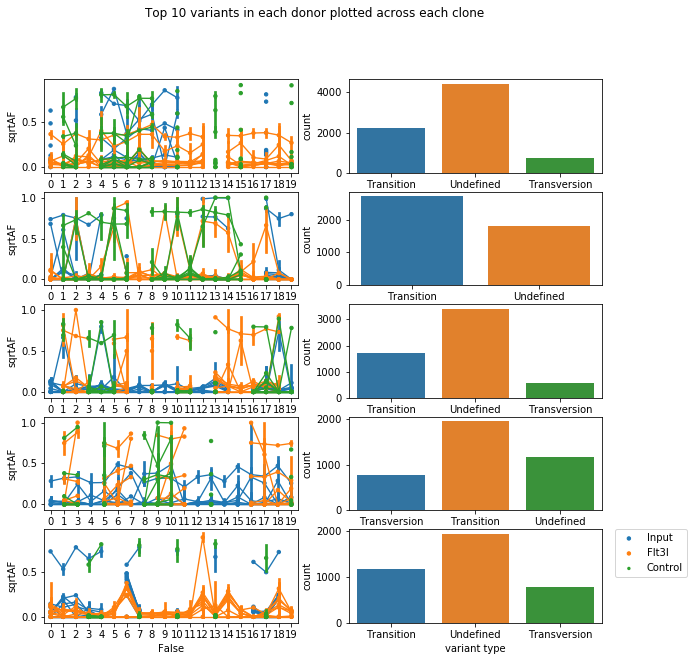

In [18]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    curr_order = np.sort(list(set(df['lineage'].values)))
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        #curr_order = np.sort(list(set(df2['lineage'].values)))
        sns.pointplot(x='lineage', y='sqrtAF', order=curr_order, data=df2, hue="condition",
                      ax=ax[d,0], scale=.5, legend=False)

        ax[d,0].set_xlabel(False)
    ax[d,0].legend().set_visible(False)
    sns.countplot(df['variant type'], ax=ax[d,1])

    
plt.suptitle(f"Top {vars_to_plot} variants in each donor plotted across each clone")
handles, labels = ax[d,0].get_legend_handles_labels()
hues = len(variants_box['condition'].unique())
l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 1.2 Plot top variants in each donor across each called clone, removing higher values

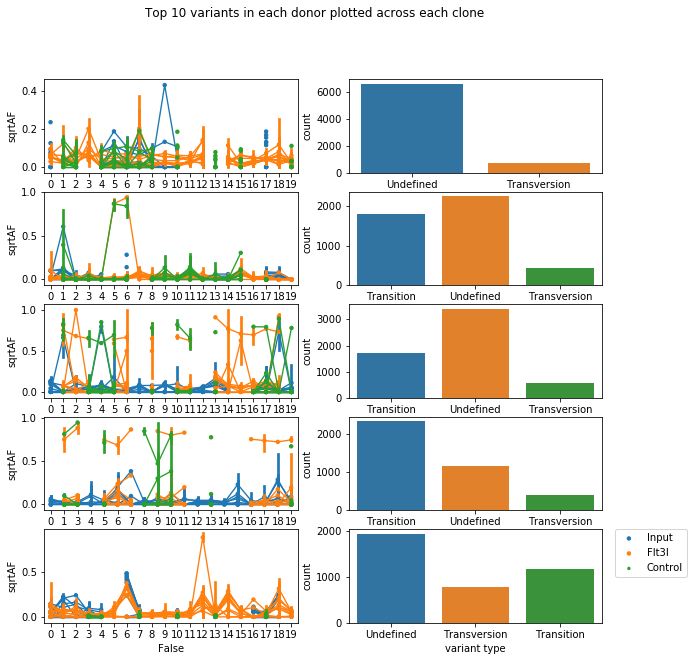

In [19]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    curr_AF = curr_AF.loc[filt_high(curr_AF, 0.1)]
    
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    curr_order = np.sort(list(set(df['lineage'].values)))
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        #curr_order = np.sort(list(set(df2['lineage'].values)))
        sns.pointplot(x='lineage', y='sqrtAF', order=curr_order, data=df2, hue="condition",
                      ax=ax[d,0], scale=.5, legend=False)

        ax[d,0].set_xlabel(False)
    ax[d,0].legend().set_visible(False)
    sns.countplot(df['variant type'], ax=ax[d,1])

    
plt.suptitle(f"Top {vars_to_plot} variants in each donor plotted across each clone")
handles, labels = ax[d,0].get_legend_handles_labels()
hues = len(variants_box['condition'].unique())
l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 2. Plot top variants in each donor across each condition

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


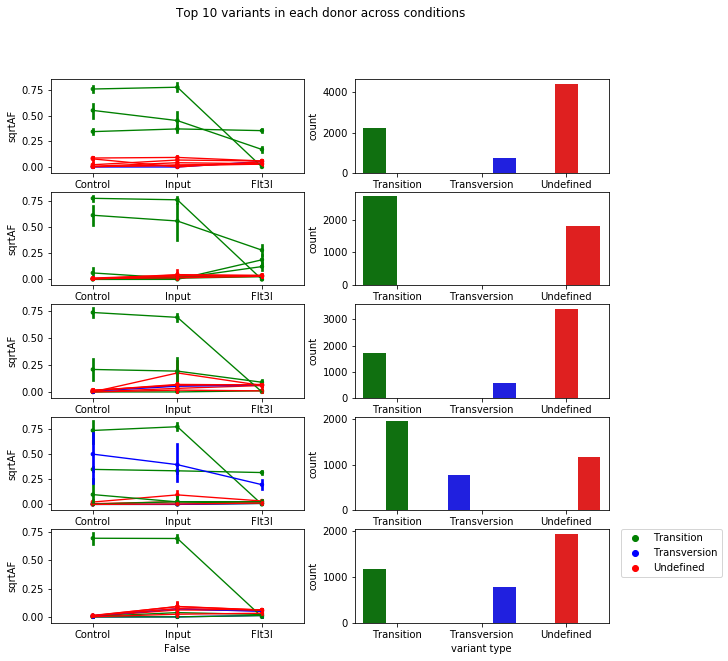

In [20]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)
colors={"Transition":"green", 'Transversion': 'blue', "Undefined": 'red'}

conditions = list(sample_names.values())

if len(conditions) < 2:
    curr_order = conditions
else:
    curr_order = [conditions[0], conditions[-1]]+ conditions[1:-1]
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        
        sns.pointplot(x='condition', y='sqrtAF', order=curr_order, data=df2,
                      ax=ax[d,0], scale=.5, legend=False, color=colors[df2["variant type"].iloc[0]])
        ax[d,0].set_xlabel(False)
    ax[d,0].legend().set_visible(False)
    sns.countplot(data=df, x='variant type', ax=ax[d,1], palette=colors, hue='variant type', order=list(colors.keys()))
    ax[d,1].legend().set_visible(False)
    
plt.suptitle(f"Top {vars_to_plot} variants in each donor across conditions")
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 2.2 Plot top variants in each donor across each condition, but removing high variants to change the scale

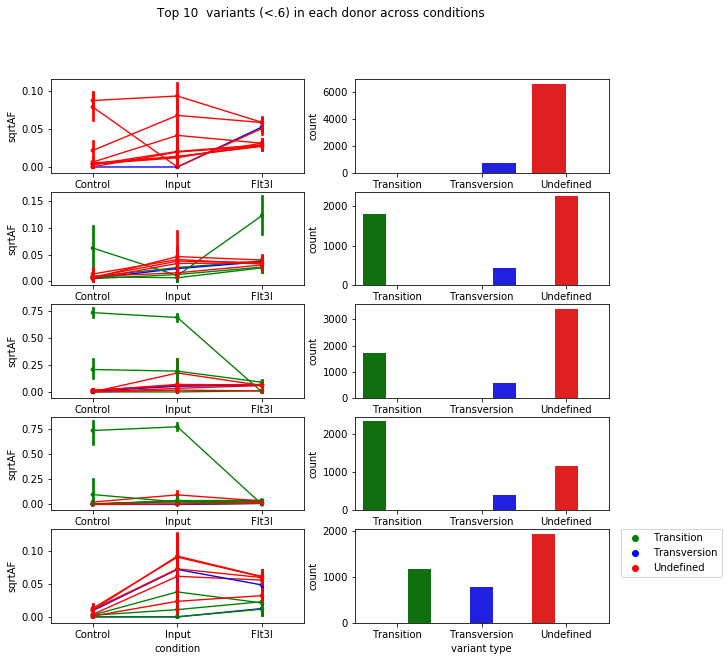

In [21]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)
colors={"Transition":"green", 'Transversion': 'blue', "Undefined": 'red'}

conditions = list(sample_names.values())

if len(conditions) < 2:
    curr_order = conditions
else:
    curr_order = [conditions[0], conditions[-1]]+ conditions[1:-1]
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    curr_AF = curr_AF.loc[filt_high(curr_AF, 0.1)]
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        
        sns.pointplot(x='condition', y='sqrtAF', order=curr_order, data=df2,
                      ax=ax[d,0], scale=.5, legend=False, color=colors[df2["variant type"].iloc[0]])
        #ax[d,0].set_xlabel(False)
    #ax[d,0].legend().set_visible(False)
    sns.countplot(data=df, x='variant type', ax=ax[d,1], palette=colors, hue='variant type', order=list(colors.keys()))
    ax[d,1].legend().set_visible(False)
    
plt.suptitle(f"Top {vars_to_plot}  variants (<.6) in each donor across conditions")
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
plt.legend(markers, colors.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [29]:
df

,Variant,Cell,AF,condition,donor,sqrtAF,variant type,lineage
0,11684N>C,ACTAGGTGTATTCACG-1_Input,0.003190,Input,4,0.056478,Undefined,0
1,6529N>G,ACTAGGTGTATTCACG-1_Input,0.000000,Input,4,0.000000,Undefined,0
2,2651N>G,ACTAGGTGTATTCACG-1_Input,0.003440,Input,4,0.058650,Undefined,0
3,14488N>A,ACTAGGTGTATTCACG-1_Input,0.021242,Input,4,0.145746,Undefined,0
4,1651216512T>A,ACTAGGTGTATTCACG-1_Input,0.001791,Input,4,0.042314,Transversion,0
...,...,...,...,...,...,...,...,...
3875,248248A>G,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transition,19
3876,1592415924A>C,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transversion,19
3877,1592415924A>G,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transition,19
3878,4428N>A,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Undefined,19


In [22]:
variants_box

,Variant,Cell,AF,condition,donor,sqrtAF,variant type,lineage
0,28752875A>G,GTTATTCCAATGCACT-1_Control,0.000000,Control,0,0.000000,Transition,0
1,95459545A>G,GTTATTCCAATGCACT-1_Control,0.011396,Control,0,0.106752,Transition,0
2,248248A>G,GTTATTCCAATGCACT-1_Control,0.000000,Control,0,0.000000,Transition,0
3,150150C>T,GTTATTCCAATGCACT-1_Control,0.388889,Control,0,0.623609,Transition,0
4,499499G>A,GTTATTCCAATGCACT-1_Control,0.232143,Control,0,0.481812,Transition,0
...,...,...,...,...,...,...,...,...
25375,71967196C>A,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transversion,19
25376,1622316223C>T,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Transition,19
25377,2017N>A,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Undefined,19
25378,5361N>C,TTGTTCAGTAGAAGCC-1_Flt3l,0.000000,Flt3l,4,0.000000,Undefined,19


## 3. Plot top variants as a column, each donor as a row, mean AF

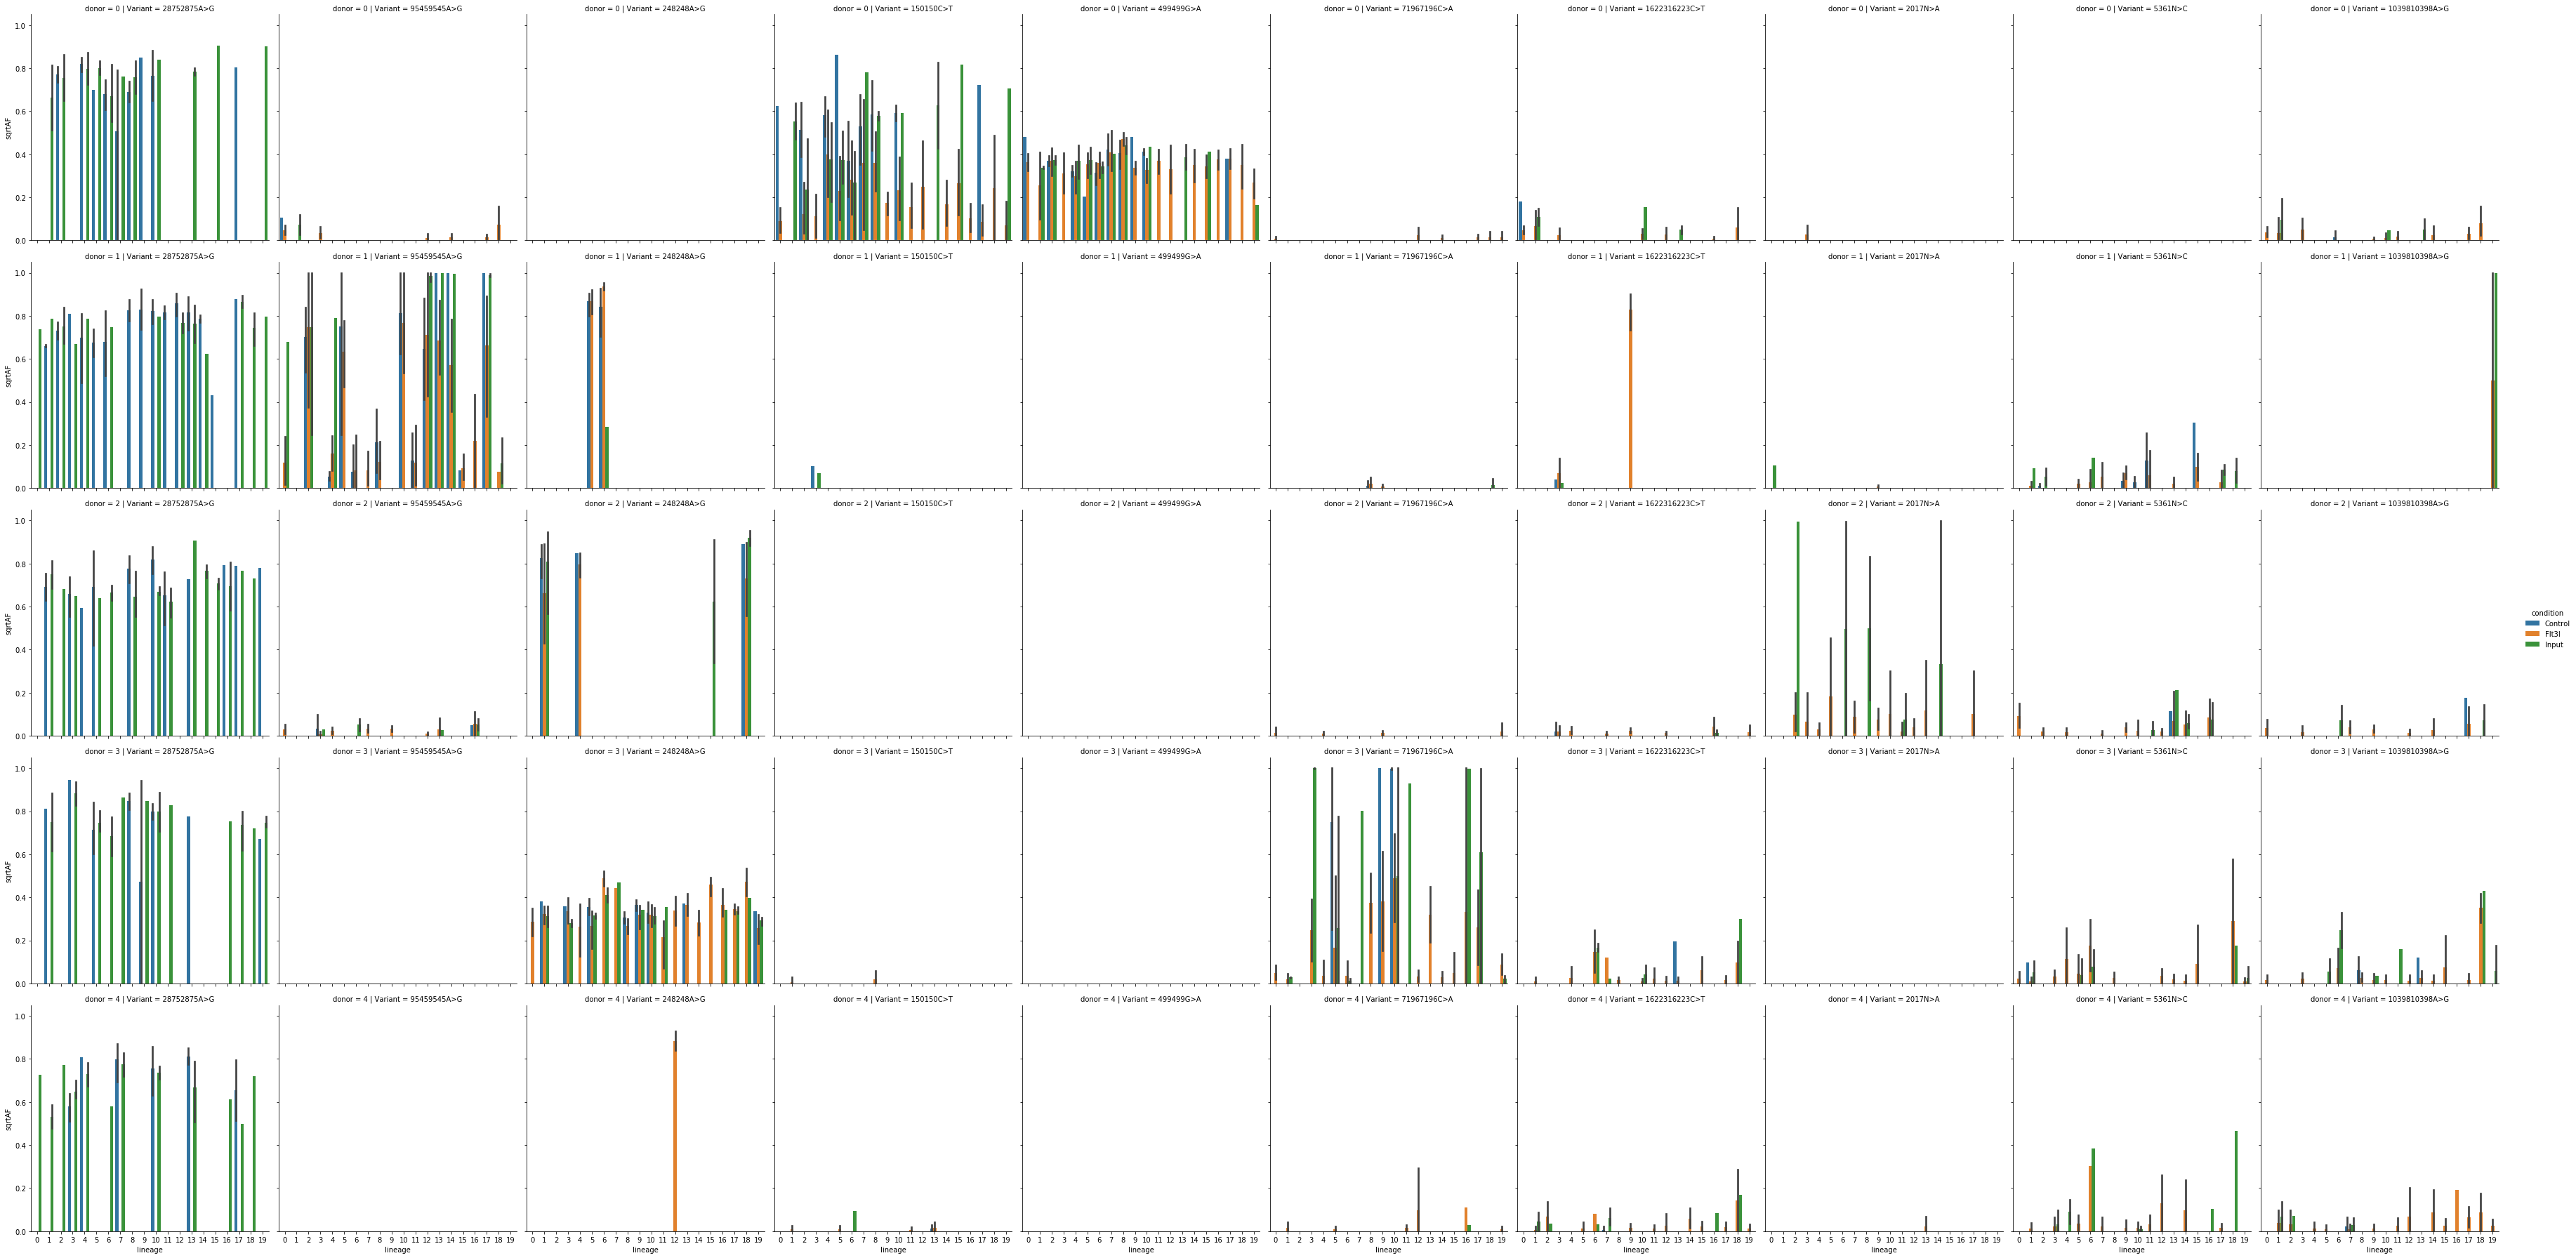

In [23]:
%matplotlib inline
#variants_box=variants_dense(AF_df, vars_to_plot)

g = sns.catplot(x='lineage', y='sqrtAF', 
                hue='condition', row='donor',col='Variant', 
                data=variants_box, 
                kind="bar", dodge=True)


In [28]:
variants_box.loc[variants_box["variant type"] == "Undefined"]['Variant']

7        2017N>A
8        5361N>C
17       2017N>A
18       5361N>C
27       2017N>A
          ...   
25358    5361N>C
25367    2017N>A
25368    5361N>C
25377    2017N>A
25378    5361N>C
Name: Variant, Length: 5076, dtype: object

In [26]:
vcf.loc[set(variants_box.loc[variants_box["variant type"] == "Undefined"]['Variant'].values)]

,index_x,#CHROM,POS,REF_x,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,...,n_cells_over_20_y,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Control/MT/cellr_True/Control_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,index,REF,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
5361N>C,5361T>C,chrM,5361,5361T,C,0.877475,0.0544417,1,0,65,...,0,54,N,N,N,N,N,N,N,65
2017N>A,2017T>A,chrM,2017,2017T,A,0.99992,0.0100895,0,0,31,...,N,N,N,N,N,N,N,N,N,31


In [31]:
curr_undefined = vcf.loc[set(df.loc[df["variant type"] == "Undefined"]['Variant'].values)]
curr_undefined

,index_x,#CHROM,POS,REF_x,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Input/MT/cellr_True/Input_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,...,n_cells_over_20_y,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Control/MT/cellr_True/Control_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,index,REF,strand_correlation,vmr,n_cells_over_5,n_cells_over_20,old data/processed/mttrace/CHIP_april08_2021_Croker/MTblacklist/Flt3l/MT/cellr_True/Flt3l_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
2651N>G,2651A>G,chrM,2651,2651A,G,0.893587,0.0110015,0,0,37,...,N,N,N,N,N,N,N,N,N,37
14488N>A,14488T>A,chrM,14488,14488T,A,0.872982,0.0417738,0,0,156,...,N,N,N,N,N,N,N,N,N,156
11684N>C,11684T>C,chrM,11684,11684T,C,0.999636,0.0129992,0,0,128,...,N,N,N,N,N,N,N,N,N,128
6529N>G,6529T>G,chrM,6529,6529T,G,0.980147,0.0156777,0,0,78,...,N,N,N,N,N,N,N,N,N,78
4428N>A,4428G>A,chrM,4428,4428G,A,0.999015,0.0860229,1,1,56,...,N,N,N,N,N,N,N,N,N,56
